In [51]:
import pickle
import numpy as np
import pandas as pd
import nltk
import string

from scipy.sparse import csr_matrix, dok_matrix
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef, classification_report

In [12]:
df = pd.read_csv("emails.csv")
X = df.Text
y = df.Spam
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
df.head()

,Text,Spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [20]:
def get_words(document):
    for word in nltk.tokenize.word_tokenize(document):
        if word not in string.punctuation:
            yield word.lower()

In [23]:
def process_documents(data):
    all_words = {}; index = 0
    emails = []
    
    for email in data:
        current = []
        for word in get_words(email):
            if word not in all_words:
                all_words|= {word:index}
                index+=1
            current.append(word)
        emails.append(current)
    return all_words, emails

In [24]:
all_words, emails = process_documents(X_train)

In [25]:
def process_test_documents(data, all_words):
    emails = []
    for email in data:
        current = []
        for word in get_words(email):
            if word in all_words:
                current.append(word)
        emails.append(current)
    return emails

In [28]:
def word_counts(document):
    return zip(*np.unique(document, return_counts=True))

In [29]:
TF = dok_matrix( 
    np.zeros( 
        shape = (len(emails), len(all_words))
    ))

for i, email in enumerate(emails):
    for word, counts in word_counts(email):
        TF[ i, all_words[word] ] += counts

## Using LDA representation to predict **HAM** or **SPAM**

In [33]:
lda = LatentDirichletAllocation().fit(TF.tocsr())

In [34]:
X_train_lda = lda.transform(TF.tocsr())

In [50]:
cross_val_score(SVC(kernel="poly"), X_train_lda, y_train, cv=10, scoring="f1").mean()

0.8335500875474466

In [52]:
cross_val_score(LogisticRegression(), X_train_lda, y_train, cv=10, scoring="f1").mean()

0.8101765307413673

In [39]:
cross_val_score(RandomForestClassifier(), X_train_lda, y_train, cv=10, scoring="f1").mean()

0.8893486519878753

Using cross validation we obtained good statistics 

## Validating on test set

In [42]:
test_emails = process_test_documents(X_test, all_words)

In [43]:
TF_test = dok_matrix(
    np.zeros((len(test_emails), len(all_words)))
)

for i, email in enumerate(test_emails):
    for word, counts in word_counts(email):
        TF_test[ i, all_words[word] ] += counts

In [44]:
X_test_lda = lda.transform(TF_test)

MFCC = 0.8080793628623474
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       885
           1       0.91      0.79      0.85       261

    accuracy                           0.93      1146
   macro avg       0.93      0.88      0.90      1146
weighted avg       0.93      0.93      0.93      1146



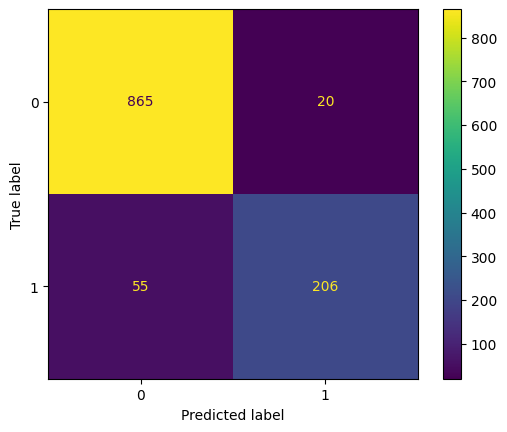

In [46]:
preds_svc = SVC().fit(X_train_lda, y_train).predict(X_test_lda)

print("MFCC =", matthews_corrcoef(y_test, preds_svc))
print(classification_report(y_test, preds_svc))

ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds_svc)
).plot()

MFCC = 0.8395131759840451
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       885
           1       0.93      0.82      0.87       261

    accuracy                           0.95      1146
   macro avg       0.94      0.90      0.92      1146
weighted avg       0.94      0.95      0.94      1146



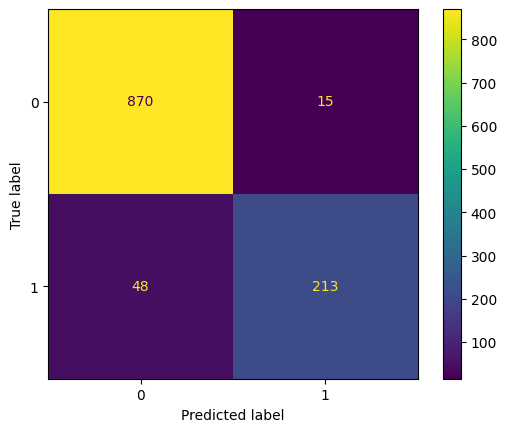

In [48]:
preds_rf = RandomForestClassifier().fit(X_train_lda, y_train).predict(X_test_lda)

print("MFCC =", matthews_corrcoef(y_test, preds_rf))
print(classification_report(y_test, preds_rf))

ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds_rf)
).plot()